In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mohsenfayyaz/.cache/huggingface/token
Login successful
CUDA_VISIBLE_DEVICES: 6 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [2]:
# DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")

'hf/results/re-docred_facebook--dragon-plus-query-encoder_7170.pkl'

In [3]:
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(1)

{'model': 'facebook/dragon-plus-query-encoder', 'query_model': 'facebook/dragon-plus-query-encoder', 'context_model': 'facebook/dragon-plus-context-encoder', 'pooling': 'cls', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.47685, 'NDCG@3': 0.52523, 'NDCG@5': 0.53646, 'NDCG@10': 0.54955, 'NDCG@100': 0.58002, 'NDCG@1000': 0.59556}, 'map': {'MAP@1': 0.47685, 'MAP@3': 0.51341, 'MAP@5': 0.51959, 'MAP@10': 0.52496, 'MAP@100': 0.53058, 'MAP@1000': 0.53109}, 'recall': {'Recall@1': 0.47685, 'Recall@3': 0.55941, 'Recall@5': 0.58689, 'Recall@10': 0.62748, 'Recall@100': 0.77741, 'Recall@1000': 0.90349}, 'precision': {'P@1': 0.47685, 'P@3': 0.18647, 'P@5': 0.11738, 'P@10': 0.06275, 'P@100': 0.00777, 'P@1000': 0.0009}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud, Loud Tour}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}]","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]",P577,publication date,When was Loud Tour published?,0,{},1.0,"Loud Tour The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the A

In [4]:
df = df_raw.copy()
df = df[df["head_entity_names"].str.len() > 1]
print(len(df))

df = df.sample(250, random_state=0)
print(len(df))

# df["head_entity_shortest_name"] = df["head_entity_names"].apply(lambda x: min(x, key=len))
df["head_entity_shortest_name"] = df.apply(lambda r: min([n for n in r['head_entity_names'] if n != r["head_entity_longest_name"]], key=len), axis=1)
df["query_long_name"] = df["query"]
df["query_short_name"] = df.apply(lambda r: r["query"].replace(r["head_entity_longest_name"], r["head_entity_shortest_name"]), axis=1)

def replace_heads(r, replacement):
    sents = r["sents"]
    head_all_pos = []
    head_start_pos = []
    for e in r["head_entity"]:
        if "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", "") != e["name"].replace(" ", ""):
            print("ERROR", e["name"].replace(" ", ""), " != ", "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", ""))
        head_start_pos.append((e["sent_id"], e["pos"][0]))
        for i in range(e["pos"][0], e["pos"][1]):
            head_all_pos.append((e["sent_id"], i))
        
    new_words = []
    for sent_id, sent in enumerate(sents):
        for wi, word in enumerate(sent):
            if (sent_id, wi) in head_start_pos:
                new_words.append(replacement)
            if (sent_id, wi) not in head_all_pos:
                new_words.append(word)
    return " ".join(new_words)
            

df["gold_doc_long_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_longest_name"]), axis=1)
df["gold_doc_short_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_shortest_name"]), axis=1)

df[["query", "query_long_name", "query_short_name", "gold_doc_long_name", "gold_doc_short_name"]].sample(5)

1878
250
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q


,query,query_long_name,query_short_name,gold_doc_long_name,gold_doc_short_name
6466,When was Fatih Terim born?,When was Fatih Terim born?,When was Terim born?,"Fatih Terim , Commendatore OSSI , T.C , ( born 4 September 1953 ) is a Turkish association football manager and former player . He is currently the manager of Galatasaray , a position he previously held three times . Fatih Terim has managed several clu...","Terim , Commendatore OSSI , T.C , ( born 4 September 1953 ) is a Turkish association football manager and former player . He is currently the manager of Galatasaray , a position he previously held three times . Terim has managed several clubs in Italy ..."
3650,What is a notable work of Jeff Healey?,What is a notable work of Jeff Healey?,What is a notable work of Jeff?,"Mess of Blues is an album by Jeff Healey . It was released in 2008 less than two weeks after his death and just three weeks shy of his 42nd birthday . Four of the album 's tracks were recorded live in front of audiences , two of the live tracks at the ...","Mess of Blues is an album by Jeff . It was released in 2008 less than two weeks after his death and just three weeks shy of his 42nd birthday . Four of the album 's tracks were recorded live in front of audiences , two of the live tracks at the Islingt..."
2826,When did Mohammed Abd el-Wahhab die?,When did Mohammed Abd el-Wahhab die?,When did Abd El - Wahhab die?,"Mohammed Abd el-Wahhab ( , Egyptian Arabic : عبد الوهـاب Mohammed Abd el-Wahhab ) , also transliterated Mohammed Abd el-Wahhab ( March 13 , 1902 – May 4 , 1991 ) was a prominent 20th - century Egyptian singer and composer . He 's best known for his Rom...","Abd El - Wahhab ( , Egyptian Arabic : عبد الوهـاب Abd El - Wahhab ) , also transliterated Abd El - Wahhab ( March 13 , 1902 – May 4 , 1991 ) was a prominent 20th - century Egyptian singer and composer . He 's best known for his Romantic and Egyptian pa..."
3825,Which sports team is Mark McNamara a member of?,Which sports team is Mark McNamara a member of?,Which sports team is McNamara a member of?,"Mark McNamara ( born June 8 , 1959 ) , is an American former professional basketball player who was selected by the Philadelphia 76ers in the first round ( 22nd overall ) of the 1982 NBA draft . A 6'11 "" power forward - center from the University of Ca...","McNamara ( born June 8 , 1959 ) , is an American former professional basketball player who was selected by the Philadelphia 76ers in the first round ( 22nd overall ) of the 1982 NBA draft . A 6'11 "" power forward - center from the University of Califor..."
4557,What is the mouth of the watercourse of Upper Ammonoosuc River?,What is the mouth of the watercourse of Upper Ammonoosuc River?,What is the mouth of the watercourse of Upper Ammonoosuc?,"The Upper Ammonoosuc River is a tributary of the Connecticut River that flows through Coös County in northern part of the northeastern U.S. state of New Hampshire . Despite its name , the river is not an upstream portion of the Ammonoosuc River , but i...","The Upper Ammonoosuc is a tributary of the Connecticut River that flows through Coös County in northern part of the northeastern U.S. state of New Hampshire . Despite its name , the river is not an upstream portion of the Ammonoosuc River , but instead..."


In [5]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", verbose=True, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.verbose = verbose
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False), disable=not self.verbose):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        if self.verbose: print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

  0%|          | 0/6 [00:00<?, ?it/s]

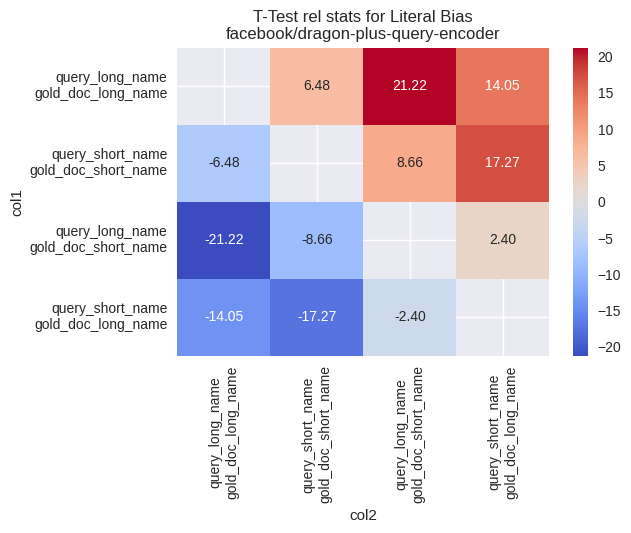

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


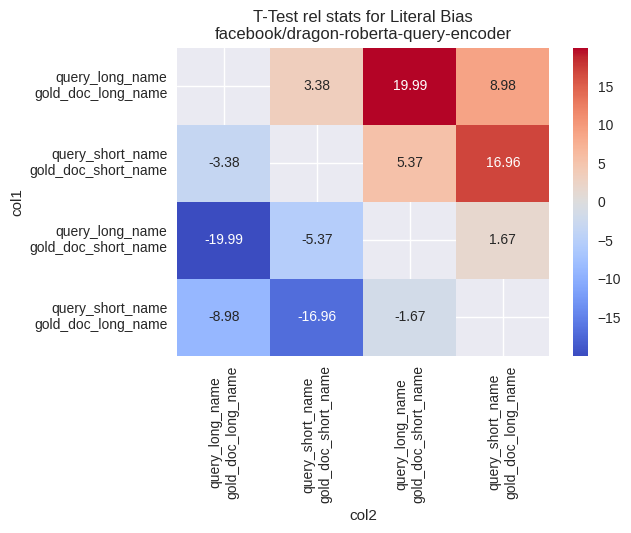

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


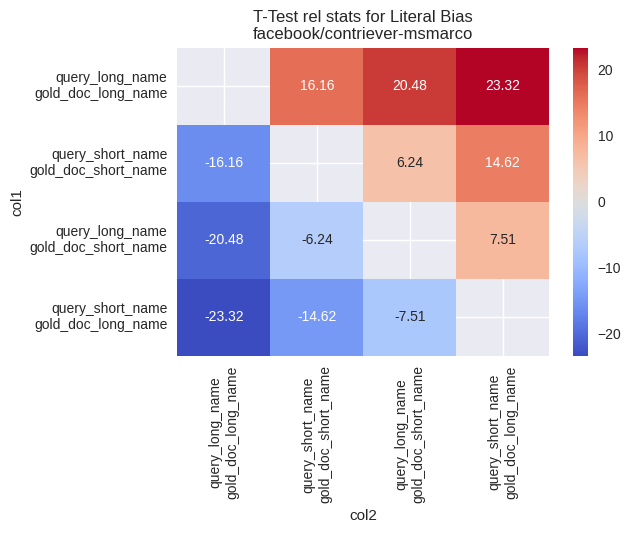

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


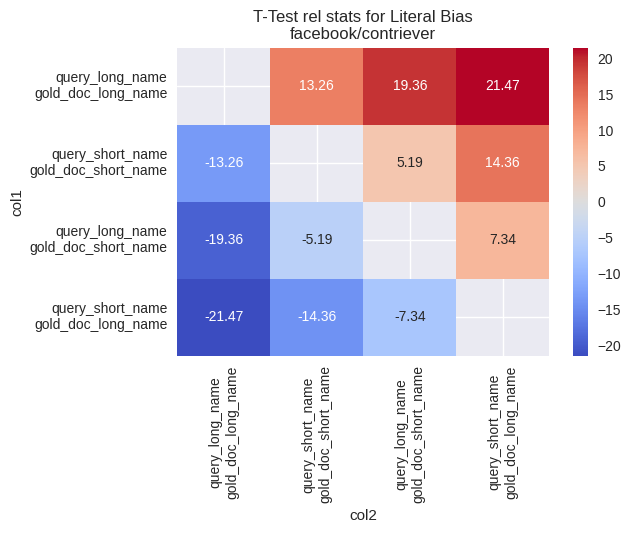

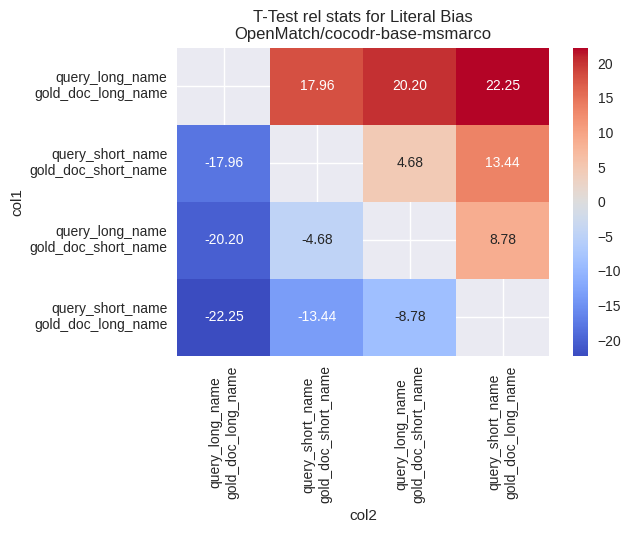

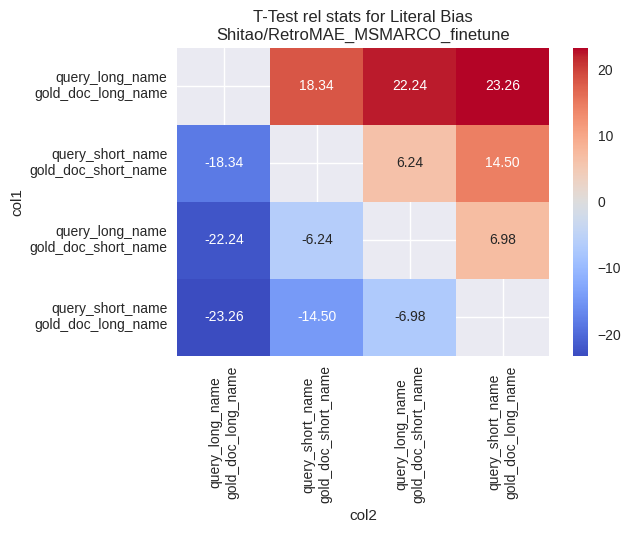

,query_model,col1,col2,ttest_stats,ttest_pvalue
0,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_long_name\ngold_doc_long_name,NaN,NaN
1,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_short_name\ngold_doc_long_name,14.050706,2.050568e-33
2,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_long_name\ngold_doc_short_name,21.216028,9.510555e-58
3,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_short_name\ngold_doc_short_name,6.477536,4.943572e-10
4,facebook/dragon-plus-query-encoder,query_short_name\ngold_doc_long_name,query_long_name\ngold_doc_long_name,-14.050706,2.050568e-33
...,...,...,...,...,...
11,Shitao/RetroMAE_MSMARCO_finetune,query_long_name\ngold_doc_short_name,query_short_name\ngold_doc_short_name,-6.238820,1.881184e-09
12,Shitao/RetroMAE_MSMARCO_finetune,query_short_name\ngold_doc_short_name,query_long_name\ngold_doc_long_name,-18.343826,3.912904e-48
13,Shitao/RetroMAE_MSMARCO_finetune,query_short_name\ngold_doc_short_name,query_short_name\ngold_doc_long_name,14.502675,5.801744e-35
14,Shitao/RetroMAE_MSMARCO_finetune,query_short_name\ngold_doc_short_name,query_long_name\ngold_doc_short_name,6.238820,1.881184e-09


In [6]:
cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]
query_cols = [
    # "query", 
    "query_long_name", "query_short_name"
]
doc_cols = [
    # "gold_doc_text", 
    "gold_doc_long_name", "gold_doc_short_name"
]

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    
    plot_col_dots = []
    
    for d_col in doc_cols:
        embds = dpr.encode_corpus(to_doc_format(df[d_col].to_list()))
        for q_col in query_cols:
            query_embds = dpr.encode_queries(df[q_col].to_list())
            embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds))
            new_col = f"{q_col}\n{d_col}"
            # print(new_col)
            df[new_col] = embds_dot.cpu().numpy()
            plot_col_dots.append(new_col)
    
    # df[plot_col_dots[::-1]].boxplot(figsize=(9, 5), rot=0, vert=False)
    # plt.title(f"{query_model}, support: {len(df)}")
    # plt.show()
    
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            rdf.append({
                "query_model": query_model,
                "col1": col1,
                "col2": col2,
                "ttest_stats": stats.ttest_rel(df[col1], df[col2])[0],
                "ttest_pvalue": stats.ttest_rel(df[col1], df[col2])[1],
            })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf])
    rdfp = rdf.pivot(index="col1", columns="col2", values="ttest_stats")
    order = [
        'query_long_name\ngold_doc_long_name', 
        'query_short_name\ngold_doc_short_name', 
        'query_long_name\ngold_doc_short_name',
        'query_short_name\ngold_doc_long_name',
    ]
    rdfp = rdfp.reindex(columns=order, level='col2')  # Sort columns
    rdfp = rdfp.reindex(order)
    plt.figure(figsize=(6, 4))
    sns.heatmap(rdfp, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"T-Test rel stats for Literal Bias\n{query_model}")
    plt.show()
    rdf
    

# results.append({
#     "query_model": query_model,
#     "context_model": context_model,
#     "POOLING": POOLING,
#     "support": len(df),
#     "query_type": q,
#     "sents_complete_w_end_dot_vs_wo": stats.ttest_rel(df["sents_complete_w_end_dot"], df["sents_complete_wo_end_dot"]),
#     "head_w_tail_dot_vs_wo": stats.ttest_rel(df["head_w_tail_dot"], df["head_wo_tail_dot"]),
#     "sents_complete_rm_wo_dot_vs_w": stats.ttest_rel(df["sents_complete_rm_head_wo_tail_dot"], df["sents_complete_rm_head_w_tail_dot"]),
# })
results_df

In [7]:
df = results_df.dropna().copy()

# df["col"] = df["col1"] + " vs " + df["col2"]

df["Query Name 1"] = df["col1"].apply(lambda x: x.split("\n")[0].split("_")[1])
df["Doc Name 1"] = df["col1"].apply(lambda x: x.split("\n")[1].split("_")[2])
df["Query Name 2"] = df["col2"].apply(lambda x: x.split("\n")[0].split("_")[1])
df["Doc Name 2"] = df["col2"].apply(lambda x: x.split("\n")[1].split("_")[2])
df = df[["query_model", "Query Name 1", "Doc Name 1", "Query Name 2", "Doc Name 2", "ttest_stats", "ttest_pvalue"]]
df = df[df["Query Name 1"] == df["Doc Name 1"]]
df = df[~((df["Query Name 2"] == "long") & (df["Doc Name 2"] == "long"))]
df = pd.pivot_table(
    df,
    values=[
        "ttest_stats", 
        # "ttest_pvalue",
    ],
    index=[
        "Query Name 1", "Doc Name 1", "Query Name 2", "Doc Name 2"
    ],
    columns=['query_model'], margins=False, aggfunc=lambda x: x.iloc[0] if len(x) == 1 else -100,
)

# LATEX
def clean_table(table_str):
    mappings = {
        "attention": "Attention",
    }
    model_mappings = {
        "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
        r"Shitao/RetroMAE\_MSMARCO\_finetune": ("RetroMAE", "MSMARCO FT"),
        r"Shitao/RetroMAE\_MSMARCO": ("RetroMAE", "MSMARCO"),
        "Shitao/RetroMAE": ("RetroMAE", ""),
        "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
        "facebook/contriever": ("Contriever", ""),
        "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
        "facebook/dragon-roberta-query-encoder": ("Dragon", "RoBERTa"),
    }
    back = "\\"
    raw_mappings = {
        # r"Method & Selection &  &  &  &  &  &  &  &  &  &  \\": "",
        r"query\_model": "Model",
        "llllrrrrrr": r"p{1.2cm}p{1.2cm}p{1.2cm}p{1.2cm}rrrrrr",
        r"\cline{1-10} \cline{2-10} \cline{3-10}": "\\midrule",
    }
    for k, v in mappings.items():
        key = k.replace('_', '\\_')
        table_str = table_str.replace("\\textbf{" + key + "}", "\\textsc{" + v + "}")
    for k, v in model_mappings.items():
        key = k
        value = r"\makecell{" + v[0] + r" \\ " + v[1] + r"}"
        table_str = table_str.replace(key, value)
    for k, v in raw_mappings.items():
        table_str = table_str.replace(k, v)
    return table_str
print(clean_table(df.round(2).to_latex(float_format="%.2f", bold_rows=True, ).replace("_", r"\_")))
# print(df.round(2).to_latex(float_format="%.2f", bold_rows=True, ).replace("_", "\_"))

df

\begin{tabular}{p{1.2cm}p{1.2cm}p{1.2cm}p{1.2cm}rrrrrr}
\toprule
 &  &  &  & \multicolumn{6}{r}{ttest\_stats} \\
 &  &  & Model & \makecell{COCO-DR \\ Base MSMARCO} & \makecell{RetroMAE \\ MSMARCO FT} & \makecell{Contriever \\ } & \makecell{Contriever \\ MSMARCO} & \makecell{Dragon+ \\ } & \makecell{Dragon \\ RoBERTa} \\
Query Name 1 & Doc Name 1 & Query Name 2 & Doc Name 2 &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{\textbf{long}} & \multirow[t]{3}{*}{\textbf{long}} & \textbf{long} & \textbf{short} & 20.20 & 22.24 & 19.36 & 20.48 & 21.22 & 19.99 \\
\cline{3-10}
\textbf{} & \textbf{} & \multirow[t]{2}{*}{\textbf{short}} & \textbf{long} & 22.25 & 23.26 & 21.47 & 23.32 & 14.05 & 8.98 \\
\textbf{} & \textbf{} & \textbf{} & \textbf{short} & 17.96 & 18.34 & 13.26 & 16.16 & 6.48 & 3.38 \\
\midrule
\multirow[t]{2}{*}{\textbf{short}} & \multirow[t]{2}{*}{\textbf{short}} & \textbf{long} & \textbf{short} & 4.68 & 6.24 & 5.19 & 6.24 & 8.66 & 5.37 \\
\cline{3-10}
\textbf{} & \textbf{} & \text

ttest_stats  \
query_model                                     OpenMatch/cocodr-base-msmarco   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                                 
long         long       long         short                          20.201100   
                        short        long                           22.246187   
                                     short                          17.957128   
short        short      long         short                           4.681255   
                        short        long                           13.436749   

                                                                                  \
query_model                                     Shitao/RetroMAE_MSMARCO_finetune   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                                    
long         long       long         short                             22.236600   
                        short        long                              23.263894   
                                     short                             18.343826   
short        short      long         short                              6.238820   
                        short        long                              14.502675   

                                                                     \
query_model                                     facebook/contriever   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                       
long         long       long         short                19.358738   
                        short        long                 21.469019   
                                     short                13.261511   
short        short      long         short                 5.185824   
                        short        long                 14.360573   

                                                                             \
query_model                                     facebook/contriever-msmarco   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                               
long         long       long         short                        20.480854   
                        short        long                         23.319246   
                                     short                        16.156691   
short        short      long         short                         6.239382   
                        short        long                         14.624574   

                                                                                    \
query_model                                     facebook/dragon-plus-query-encoder   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                                      
long         long       long         short                               21.216028   
                        short        long                                14.050706   
                                     short                                6.477536   
short        short      long         short                                8.658077   
                        short        long                                17.271908   

                                                                                       
query_model                                     facebook/dragon-roberta-query-encoder  
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                                        
long         long       long         short                                  19.992441  
                        short        long                                    8.982492  
                                     short                                   3.376552  
short        short      long         short                                   5.371656  
                        short        long                                   16.964410

In [8]:
order = [
    'query_long_name\ngold_doc_long_name', 
    'query_short_name\ngold_doc_short_name', 
    'query_long_name\ngold_doc_short_name',
    'query_short_name\ngold_doc_long_name',
]
rdfp2 = rdfp.reindex(columns=order, level='col2')  # Sort columns
rdfp2 = rdfp2.reindex(order)
rdfp2

col2,query_long_name\ngold_doc_long_name,query_short_name\ngold_doc_short_name,query_long_name\ngold_doc_short_name,query_short_name\ngold_doc_long_name
col1,,,,
query_long_name\ngold_doc_long_name,NaN,18.343826,22.236600,23.263894
query_short_name\ngold_doc_short_name,-18.343826,NaN,6.238820,14.502675
query_long_name\ngold_doc_short_name,-22.236600,-6.238820,NaN,6.984938
query_short_name\ngold_doc_long_name,-23.263894,-14.502675,-6.984938,NaN


: 

# Ttest Binary

In [38]:
df = df_raw.copy()
df = df[df["head_entity_names"].str.len() > 1]
print(len(df))

df = df.sample(250, random_state=0)
print(len(df))

# df["head_entity_shortest_name"] = df["head_entity_names"].apply(lambda x: min(x, key=len))
df["head_entity_shortest_name"] = df.apply(lambda r: min([n for n in r['head_entity_names'] if n != r["head_entity_longest_name"]], key=len), axis=1)
df["query_long_name"] = df["query"]
df["query_short_name"] = df.apply(lambda r: r["query"].replace(r["head_entity_longest_name"], r["head_entity_shortest_name"]), axis=1)

def replace_heads(r, replacement):
    sents = r["sents"]
    head_all_pos = []
    head_start_pos = []
    for e in r["head_entity"]:
        if "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", "") != e["name"].replace(" ", ""):
            print("ERROR", e["name"].replace(" ", ""), " != ", "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", ""))
        head_start_pos.append((e["sent_id"], e["pos"][0]))
        for i in range(e["pos"][0], e["pos"][1]):
            head_all_pos.append((e["sent_id"], i))
        
    new_words = []
    for sent_id, sent in enumerate(sents):
        for wi, word in enumerate(sent):
            if (sent_id, wi) in head_start_pos:
                new_words.append(replacement)
            if (sent_id, wi) not in head_all_pos:
                new_words.append(word)
    return " ".join(new_words)
            

df["gold_doc_long_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_longest_name"]), axis=1)
df["gold_doc_short_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_shortest_name"]), axis=1)

df[["query", "query_long_name", "query_short_name", "gold_doc_long_name", "gold_doc_short_name"]].sample(5)

1878
250
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q


,query,query_long_name,query_short_name,gold_doc_long_name,gold_doc_short_name
1098,Which administrative territorial entity is Tommy James and the Shondells located in?,Which administrative territorial entity is Tommy James and the Shondells located in?,Which administrative territorial entity is James and the Shondells located in?,""" I Think We 're Alone Now "" is a song written and composed by Ritchie Cordell that was the title selection from a same - named album released by the American recording artists Tommy James and the Shondells . "" I Think We 're Alone Now "" was a 1967 US hit for Tommy James and the Shondells , reaching number 4 on the Billboard Hot 100 chart . The song has since been covered several times by other artists . The late 1987 recording by Tiffany reached number 1 on the charts of various countries including the US , UK , Canada , and New Zealand . Other cover versions have also charted , including those by The Rubinoos ( number 45 US , 1977 ) and Girls Aloud ( number 4 UK , 2006 ) .",""" I Think We 're Alone Now "" is a song written and composed by Ritchie Cordell that was the title selection from a same - named album released by the American recording artists James and the Shondells . "" I Think We 're Alone Now "" was a 1967 US hit for James and the Shondells , reaching number 4 on the Billboard Hot 100 chart . The song has since been covered several times by other artists . The late 1987 recording by Tiffany reached number 1 on the charts of various countries including the US , UK , Canada , and New Zealand . Other cover versions have also charted , including those by The Rubinoos ( number 45 US , 1977 ) and Girls Aloud ( number 4 UK , 2006 ) ."
3830,Who developed Nexus Q?,Who developed Nexus Q?,Who developed Nexus Q?,"Nexus Q is a discontinued digital media player developed by Google . Unveiled at the Google I / O developers ' conference on June 2012 , the device was expected to be released to the public in the United States shortly thereafter for US$ 300 . The Nexus Q was designed to leverage Google 's online media offerings , such as Google Play Music , Google Play Movies & TV , and YouTube , to provide a "" shared "" experience . Users could stream content from the supported services to a connected television , or speakers connected to an integrated amplifier , using their Android device and the services ' respective apps as a remote control for queueing content and controlling playback . The Nexus Q received mixed reviews from critics following its unveiling . While its unique spherical design was praised , the Nexus Q was criticized for its lack of functionality in comparison to similar devices such as Apple TV , including a lack of third - party content services , no support for streaming content directly from other devices using the DLNA standard , as well as other software issues that affected the usability of the device . The unclear market positioning of the Nexus Q was also criticized , as it carried a significantly higher price than competing media players with wider capabilities ; The New York Times technology columnist David Pogue described the device as being ' wildly overbuilt ' for its limited functions . The Nexus Q was given away at no cost to attendees of Google I / O 27 - 29 June 2012 , but the product 's consumer launch was postponed in July 2012 , purportedly to collect additional feedback . Those who had pre - ordered the Nexus Q following its unveiling received the device at no cost . The Nexus Q was quietly shelved in January 2013 , and sup...","Nexus Q is a discontinued digital media player developed by Google . Unveiled at the Google I / O developers ' conference on June 2012 , the device was expected to be released to the public in the United States shortly thereafter for US$ 300 . The Nexus Q was designed to leverage Google 's online media offerings , such as Google Play Music , Google Play Movies & TV , and YouTube , to provide a "" shared "" experience . Users could s

In [39]:
sents_cols = [("query_short_name", "gold_doc_short_name"), ("query_short_name", "gold_doc_long_name"),]

In [40]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    for query_col, sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        query_embds = dpr.encode_queries(df[query_col].to_list())
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{query_col}{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot = df.copy()

  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/dragon-roberta-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever:   0%|          | 0/2 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/2 [00:00<?, ?it/s]

In [41]:
df_dot.head(1)

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,head_entity_shortest_name,query_long_name,query_short_name,gold_doc_long_name,gold_doc_short_name,facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_long_name_dot,facebook/contriever-msmarco_query_short_namegold_doc_short_name_dot,facebook/contriever-msmarco_query_short_namegold_doc_long_name_dot,facebook/contriever_query_short_namegold_doc_short_name_dot,facebook/contriever_query_short_namegold_doc_long_name_dot,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_short_name_dot,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_long_name_dot,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_short_name_dot,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_long_name_dot
3883,validation1271,When was Fyllingen Fotball founded?,[Fyllingen Fotball],"{'Fyllingen Fotball': {'text': 'Fyllingen Fotball was a Norwegian association football club from Fyllingsdalen , Bergen , Hordaland . It was founded as a formally independent section of the alliance sports club Fyllingen IL on 1 January 1994 . Fyllingen IL was founded on 6 June 1946 . Fyllingen Fotball still uses Fyllingen IL 's logo . The club played in the Norwegian Premier League in 1990 , 1991 and 1993 , and reached the Norwegian Cup final in 1990 , where they lost 5–1 against Rosenborg . This earned them a place in the 1991–92 European Cup Winners ' Cup , where they were eliminated by Atlético Madrid in the first round . Fyllingen played in the First Division from 1994 to 1996 and in the Second Division from 1997 till 2009 . The last two seasons of its existence , the club played in the Third Division . After the 2011 season , Fyllingen merged with Løv - Ham to create FK Fyllingsdalen , and the two clubs ceased to exist .', 'title': 'Fyllingen Fotball'}}","{'len': 1000, 'max': 396.67138671875, 'min': 377.31573486328125, 'std': 1.4577101677065352, 'mean': 378.7356885681152, 'median': 378.3219757080078}",{'Fyllingen Fotball': 396.67138671875},"{'Fyllingen Fotball': 396.67138671875, 'Selsbakk IF': 386.3876953125, 'Mikael Heggelund Foslie': 385.544677734375, 'Sandefjord BK': 385.46539306640625, 'Roy Wassberg': 385.34625244140625, 'Strømsgodset IF': 385.32843017578125, 'Morten Tandberg': 384.43414306640625, 'TrønderBilene': 383.8531799316406, 'Trond Bjørndal': 383.6851806640625, 'Helgelandske': 383.5710144042969, 'Faroese Society': 383.1950378417969, 'Larvik Turn': 383.0293884277344, 'Norwegian Financial Services Association': 382.982666015625, 'Aktiv SK': 382.7577209472656, 'Redbergslids IK Fotboll': 382.7233581542969, 'Drammen HK': 382.7122802734375, 'Fudan Fuzhong Overseas Foundation': 382.7034912109375, 'Erling Foss': 382.62994384765625, 'Kl

['facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot', 'facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot', 'facebook/dragon-roberta-query-encoder_query_short_namegold_doc_short_name_dot', 'facebook/dragon-roberta-query-encoder_query_short_namegold_doc_long_name_dot', 'facebook/contriever-msmarco_query_short_namegold_doc_short_name_dot', 'facebook/contriever-msmarco_query_short_namegold_doc_long_name_dot', 'facebook/contriever_query_short_namegold_doc_short_name_dot', 'facebook/contriever_query_short_namegold_doc_long_name_dot', 'OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_short_name_dot', 'OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_long_name_dot', 'Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_short_name_dot', 'Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_long_name_dot']


  0%|          | 0/6 [00:00<?, ?it/s]

,Model,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low,ttest_ci_high,mean_diff,std_diff,n
0,COCO-DR Base MSMARCO,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_short_name_dot,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_long_name_dot,13.518174,1.346745e-31,1.650996,1.650996,2.260753,2.644266,250
0,Contriever,facebook/contriever_query_short_namegold_doc_short_name_dot,facebook/contriever_query_short_namegold_doc_long_name_dot,14.360786,1.778661e-34,1.650996,1.650996,0.143195,0.157659,250
0,RetroMAE MSMARCO FT,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_short_name_dot,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_long_name_dot,14.514246,5.294960e-35,1.650996,1.650996,3.822672,4.164306,250
0,Contriever MSMARCO,facebook/contriever-msmarco_query_short_namegold_doc_short_name_dot,facebook/contriever-msmarco_query_short_namegold_doc_long_name_dot,14.634827,2.042144e-35,1.650996,1.650996,0.211905,0.228941,250
0,Dragon RoBERTa,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_long_name_dot,17.077737,8.218781e-44,1.650996,1.650996,4.368895,4.044932,250
0,Dragon+,facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot,17.270524,1.796319e-44,1.650996,1.650996,4.643155,4.250868,250


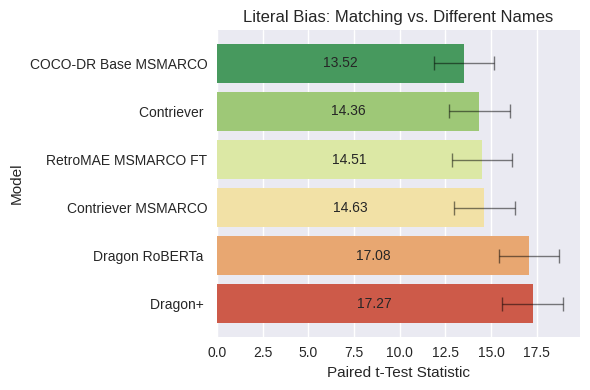

In [42]:
df = df_dot.copy()
print(plot_col_dots)

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_query")[0] and query_model == col2.split("_query")[0] and col1 != col2 and "query_short_namegold_doc_short" in col1:
                rdf.append({
                    "query_model": query_model,
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": stats.ttest_rel(df[col1], df[col2])[0],
                    "ttest_pvalue": stats.ttest_rel(df[col1], df[col2])[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                    "mean_diff": (df[col1] - df[col2]).mean(),
                    "std_diff": (df[col1] - df[col2]).std(),
                    "n": len(df),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("ttest_stats", ascending=True)

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model"}, inplace=True)
plt.figure(figsize=(6, 4))
plt.title("Literal Bias: Matching vs. Different Names")
ax = sns.barplot(data=results_df, y="Model", x="Paired t-Test Statistic", palette=sns.color_palette("RdYlGn_r"), hue="Model")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
ax.errorbar(x=results_df["Paired t-Test Statistic"], y=results_df["Model"], xerr=results_df[["ttest_ci_low", "ttest_ci_high"]].T.to_numpy(), fmt="none", c="k", capsize=5, elinewidth=1, markeredgewidth=1, alpha=0.5)
results_df.to_json("results/literal_df.json", orient="records")
# ax.bar_label(ax.containers[0], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')
# ax.bar_label(ax.containers[1], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')

plt.tight_layout()
plt.savefig("figs/literal_ttest.pdf")
results_df

In [45]:
# Find Example
pd.set_option('display.max_colwidth', 1800)
df = df_dot.copy()
df["diff"] = df["facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot"] - df["facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot"]
# df["evidence_text"] = df["evidence_sents"].apply(lambda x: " ".join(flatten(x)))
# df["evidence_len"] = df["evidence_text"].apply(lambda x: len(x.split()))
print(df["gold_doc_len"].describe())
df = df[df["gold_doc_len"] < 270]
cols = [sents_cols[0][0], sents_cols[0][1], sents_cols[1][0], sents_cols[1][1]]
df = df[cols + ["title", "query", "diff", "head_entity_names"]].sort_values("diff", ascending=False)
df[df["gold_doc_long_name"].str.contains("Go")]

count    250.0000
mean     191.3360
std       51.5575
min      132.0000
25%      155.0000
50%      174.0000
75%      216.0000
max      429.0000
Name: gold_doc_len, dtype: float64


,query_short_name,gold_doc_short_name,query_short_name,gold_doc_long_name,title,query,diff,head_entity_names
877,Who developed Iota?,"Iota is a multi - directional shooter video game developed by Zippo Games and Rare and published by Tradewest . It was released in North America on 14 October 1990 and in Europe on 26 September 1991 for the Nintendo Entertainment System . The game is the third instalment of the Jetman series and was later re - released by Nintendo for their NES - based PlayChoice-10 arcade system in the United States in 1990 . In the game , series protagonist Jetman must manoeuvre his small craft through caverns of various planets whilst searching for pieces of the Golden Warpship . The game is presented in a horizontal side - view environment and has ranging gravitational pulls for each planet , which subjects Jetman 's craft to various forms of inertia . Similar to its predecessors , Jetman must keep his craft topped up with fuel in order to progress through levels . The game was developed mostly by Mancunian developer Zippo Games under the name of Iota before being ordered to change the game into a Jetman title by Rare . Ports of the game for the ZX Spectrum , Commodore 64 and Atari ST were completed but not released due to poor sales of the NES version . The game received mostly positive reviews upon release , with critics praising the game 's presentation and graphics , however criticism was directed at the game 's difficulty . It was later included in Rare 's 2015 Xbox One retrospective compilation , Rare Replay .",Who developed Iota?,"Solar Jetman : Hunt for the Golden Warpship is a multi - directional shooter video game developed by Zippo Games and Rare and published by Tradewest . It was released in North America on 14 October 1990 and in Europe on 26 September 1991 for the Nintendo Entertainment System . The game is the third instalment of the Jetman series and was later re - released by Nintendo for their NES - based PlayChoice-10 arcade system in the United States in 1990 . In the game , series protagonist Jetman must manoeuvre his small craft through caverns of various planets whilst searching for pieces of the Golden Warpship . The game is presented in a horizontal side - view environment and has ranging gravitational pulls for each planet , which subjects Jetman 's craft to various forms of inertia . Similar to its predecessors , Jetman must keep his craft topped up with fuel in order to progress through levels . The game was developed mostly by Mancunian developer Zippo Games under the name of Solar Jetman : Hunt for the Golden Warpship before being ordered to change the game into a Jetman title by Rare . Ports of the game for the ZX Spectrum , Commodore 64 and Atari ST were completed but not released due to poor sales of the NES version . The game received mostly positive reviews upon release , with critics praising the game 's presentation and graphics , however criticism was directed at the game 's difficulty . It was later included in Rare 's 2015 Xbox One retrospective compilation , Rare Replay .",Solar Jetman,Who developed Solar Jetman : Hunt for the Golden Warpship?,16.381256,"{Solar Jetman : Hunt for the Golden Warpship, Iota}"
875,What platform is Iota available on?,"Iota is a multi - directional shooter video game developed by Zippo Games and Rare and published by Tradewest . It was released in North America on 14 October 1990 and in Europe on 26 September 1991 for the Nintendo Entertainment System . The game is the third instalment of the Jetman series and was later re - released by Nintendo for their NES - based PlayChoice-10 arcade system in the United States in 1990 . In the game , series protagonist Jetman must manoeuvre his small craft through caverns of various planets whilst searching for pieces of the Golden Warpship . The game is presented in a horizontal side - view environment and has ranging gravitational pulls for each planet , which subjects Jetman 's craft to various for